In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

from langchain.agents import initialize_agent, AgentType
from playwright.async_api import async_playwright
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from llm_experiments.models import instantiate_chat

In [2]:
model = instantiate_chat("4o-mini")

async with async_playwright() as p:
    browser = await p.chromium.launch(headless=False)
    tookkit = PlayWrightBrowserToolkit.from_browser(async_browser=browser)
    tools = tookkit.get_tools()
    agent = initialize_agent(tools, model, agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
    # await agent.ainvoke("what is the weather in tokyo?")

/var/folders/f3/ckt6hfxs32717zjcpr1f6nlr0000gn/T/ipykernel_29907/3284768707.py:7: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(tools, model, agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True)


In [3]:
from operator import add
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
from IPython.display import Image, display

In [4]:
class State(TypedDict):
    input: str
    output: str
    notepad: Annotated[list[AnyMessage], add]

In [5]:
def node_1(state: State):
    print(state)
    return {"output": "result from node 1", "notepad": ["node 1 take a note"]}

In [6]:
def node_2(state: State):
    print(state)
    return {"output": "result from node 2", "notepad": ["node 2 take a note"]}

In [11]:
def node_3(state: State):
    print(state)
    return {"notepad": ["node 3 take a note"]}

In [12]:
graph_builder = StateGraph(State)
graph_builder.add_node(node_1)
graph_builder.add_node(node_2)
graph_builder.add_node(node_3)
graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)
graph = graph_builder.compile()

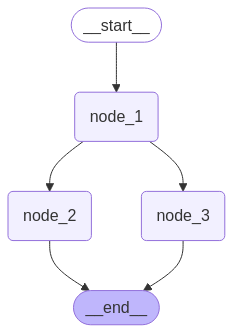

In [13]:
Image(graph.get_graph().draw_mermaid_png())

In [14]:
graph.invoke({"input": "test input"})

{'input': 'test input', 'notepad': []}
{'input': 'test input', 'output': 'result from node 1', 'notepad': ['node 1 take a note']}
{'input': 'test input', 'output': 'result from node 1', 'notepad': ['node 1 take a note']}


{'input': 'test input',
 'output': 'result from node 2',
 'notepad': ['node 1 take a note', 'node 2 take a note', 'node 3 take a note']}